In [1]:
# Zemberek'i kullanabillmek için ilk önce java kütüphenelerini kullanmamızı sağlayan kütüphaneyi ekleyelim
import jpype
from jpype import JClass, JString, getDefaultJVMPath, shutdownJVM, startJVM, java

In [2]:
# Zembrek'in jar dosyalarını okuyalım ve hangi modüller var bakalım
from zipfile import *
import zipfile

def read_jar(jar_file):
    zf = zipfile.ZipFile(jar_file, 'r')
    try:
        lst = zf.infolist()
        for zi in lst:
            fn = zi.filename 
    finally:
        zf.close()
        
read_jar("zemberek-full.jar")

In [3]:
# Zembrek'i çalıştıralım
jar = r"C:/Users/Dilemre/Documents/GitHub/bitirme/zemberek-full.jar" # Zemberek'in yolu
jvmpath = r"C:/Program Files/Java/jdk-17.0.2/bin/server/jvm.dll" # JVM'in yolu
if not jpype.isJVMStarted():
    jpype.startJVM(jvmpath=jvmpath, classpath=jar)
    print("ok")

ok


In [4]:
# Zemberekten gerekili kütüphaneleri import edelim
try:
    TurkishTokenizer = JClass('zemberek.tokenization.TurkishTokenizer')
    Token = JClass('zemberek.tokenization.Token')
    TurkishMorphology = JClass('zemberek.morphology.TurkishMorphology')
    TurkishSpellChecker = JClass('zemberek.normalization.TurkishSpellChecker')
    WordAnalysis =  JClass('zemberek.morphology.analysis.WordAnalysis')
    TurkishSentenceExtractor = JClass('zemberek.tokenization.TurkishSentenceExtractor')
except:
    print("wrong path")

In [5]:
morphology = TurkishMorphology.createWithDefaults()
tokenizer = TurkishTokenizer.ALL
spell_checker = TurkishSpellChecker(morphology)
extractor = TurkishSentenceExtractor.DEFAULT

In [6]:
#Verilerimizi almak ve işlemek için gerekli kütüphaneler
import pandas as pd
import numpy as np
import string

In [7]:
data = pd.read_csv("ndata.csv")
data

,info,title,caption,link,text
0,"19 Mart 2021, Cuma",MEHMET BARLAS,Türk siyasetinde Devlet Bahçeli bir tutarlılık...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nDün MHP'nin Büyük Kurultay'ında Genel Başk...
1,"18 Mart 2021, Perşembe",MEHMET BARLAS,Amerikan iç politikasında kimin kimi hedef ala...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nAmerikan iç politikasındaki gelişmeler kes...
2,"17 Mart 2021, Çarşamba",MEHMET BARLAS,"Amerikalılar, yalancı Amerikan başkanlarını ar...",https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nBugüne kadar her konuda Yunanistan'ın ve K...
3,"16 Mart 2021, Salı",MEHMET BARLAS,Darbeler geçmişte Türkiye’nin dış politikasını...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,"\n\nMısır'la diplomatik ilişkilerin başlaması,..."
4,"15 Mart 2021, Pazartesi",MEHMET BARLAS,"Müflis Yunanistan, Türkiye’ye gövde gösterisi ...",https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nTabii ki hiçbir ülkeyi küçük görmemek gere...
...,...,...,...,...,...
2410,"18 Şubat 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Takım ruhu lider yapar,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nAntalya'nın her alanda kurtuluşu takım ruh...
2411,"11 Şubat 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Önemli gün,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nBugün Antalya için çok önemli bir gün.\r\n...
2412,"28 Ocak 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Haydi maça,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nAntalya'da spor ve kardeşlik adına önemli ...
2413,"21 Ocak 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Laf-ı güzaf,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nDün bizim gazetenin manşet haberi Antalya ...


In [105]:
# Dengesiz bir verimiz var
data.title.value_counts().describe()

count    204.000000
mean      11.838235
std        8.208389
min        1.000000
25%        2.000000
50%       17.000000
75%       20.000000
max       20.000000
Name: title, dtype: float64

In [124]:
data.drop(data[data.title.value_counts() < 5].index, inplace=True)
data

C:\Users\Dilemre\AppData\Local\Temp/ipykernel_13304/2263789641.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data.drop(data[data.title.value_counts() < 5].index, inplace=True)


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [9]:
def dataCleaning(text):
    """Satır boşluklarını kaldır, metini küçük harfe çevir, noktalama işaretlerini kaldır"""
    text = text.replace("\n", " ")
    text = text.lower()
    text = "".join([i for i in text if (i.isalnum() or i == " ")])
    return " ".join(text.split())


def removeStopwords(text):
    """Zemberek'ten aldığımız stopword kelimelerini kaldırır"""
    stopwords = [x.strip() for x in open('stop-words.txt','r', encoding="UTF8").read().split('\n')]
    for word in text:
        if word in stopwords or word in string.whitespace:
            text.remove(word)
    return text


def wordTokenize(text):
    """Önişlenmiş metini kelimelere ayırır ve stopword'leri kaldırır"""
    text = text.split(" ")
    text = removeStopwords(text)
    return text


def sentTokenize(text):
    """Önişlenmemiş metini cümlelerine ayırır, bunişlem sırasında önişleme yapar ve stopword'leri kaldırır """
    sent_list = []
    text = text.replace("\"", "")
    results: TurkishSentenceExtractor = extractor.fromDocument(jpype.JString(text))
    for result in results:
        result = dataCleaning(str(result))
        result = removeStopwords(result.split(" "))
        if len(result) == 0:
            continue
        else:
            sent_list.append(" ".join(result))         
    return sent_list


def lemmas(word_list):
    """Kelime token'larından kök tokenları oluşturur"""
    lemma = []
    for word in word_list:
        result = str(morphology.analyzeAndDisambiguate(word).bestAnalysis()[0].getLemmas()[0])
        if result == "UNK":
            lemma.append(word)
        else:
            lemma.append(result)
    return lemma


def wtDist(wt):
    """Kelimelerin dağılımları"""
    wt_dist = dict()
    wt_dist.fromkeys(set(wt))
    for i in set(wt):
        wt_dist[i] = wt.count(i)
    return wt_dist


def wtLenDist(wt):
    """Kelimelerin harf olarak uzunluk dağılımlarını çıkarır"""
    wt_len = [len(str(word)) for word in wt]
    wt_len_dist = dict()
    wt_len_dist.fromkeys(set(wt_len))
    for i in set(wt_len):
        wt_len_dist[i] = wt_len.count(i)
    return wt_len_dist


def stLenDist(st):
    "Cümlelerin kelime olarak uzunluk dağılımlarını çıkarır"
    st_len = [len(wordTokenize(sent)) for sent in st]
    st_len_dist = dict()
    st_len_dist.fromkeys(set(st_len))
    for i in set(st_len):
        st_len_dist[i] = st_len.count(i)
    return st_len_dist


def typeTokenRatio(wt):
    """Kelimenin toplam kelime sayısına oranı"""
    return len(wt)/len(set(wt))

In [10]:
data['clean_text'] = data['text'].apply(lambda x : dataCleaning(x))

In [11]:
data['word_token'] = data['clean_text'].apply(lambda x : wordTokenize(x))

In [12]:
data['sent_token'] = data['text'].apply(lambda x : sentTokenize(x))

In [13]:
data['lemma_token'] = data['sent_token'].apply(lambda x : lemmas(x))

In [14]:
data['ltDist'] = data['lemma_token'].apply(lambda x : wtDist(x))

In [15]:
data['wtLenDist'] = data['word_token'].apply(lambda x : wtLenDist(x))

In [16]:
data['stLenDist'] = data['sent_token'].apply(lambda x : stLenDist(x))

In [17]:
data['ttr'] = data['word_token'].apply(lambda x : typeTokenRatio(x))

In [18]:
data['lttr'] = data['lemma_token'].apply(lambda x : typeTokenRatio(x))

In [72]:
# yazarları tam sayı olarak kodlar
data['target'] = pd.factorize(data.title)[0]

In [73]:
data

,info,title,caption,link,text,clean_text,word_token,sent_token,lemma_token,ltDist,wtLenDist,stLenDist,ttr,lttr,target
0,"19 Mart 2021, Cuma",MEHMET BARLAS,Türk siyasetinde Devlet Bahçeli bir tutarlılık...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nDün MHP'nin Büyük Kurultay'ında Genel Başk...,dün mhpnin büyük kurultayında genel başkan dev...,"[mhpnin, büyük, kurultayında, genel, başkan, d...",[mhpnin büyük kurultayında genel başkan devlet...,"[mhp, dün, devlet, istikrar, bahçe, cumhurbaşk...","{'istiklal': 1, 'kazan': 1, 'bölücü': 1, 'türk...","{2: 3, 3: 15, 4: 10, 5: 21, 6: 33, 7: 24, 8: 3...","{1: 1, 2: 3, 3: 2, 4: 2, 5: 1, 6: 2, 9: 3, 10:...",1.144578,1.352941,0
1,"18 Mart 2021, Perşembe",MEHMET BARLAS,Amerikan iç politikasında kimin kimi hedef ala...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nAmerikan iç politikasındaki gelişmeler kes...,amerikan iç politikasındaki gelişmeler kesinli...,"[amerikan, iç, politikasındaki, gelişmeler, bi...",[amerikan iç politikasındaki gelişmeler bizimk...,"[amerikan, bide, iş, ara, meghan markleı sonun...","{'putin': 2, 'başkan': 1, 'bide': 2, 'bu': 2, ...","{1: 2, 2: 6, 3: 12, 4: 30, 5: 48, 6: 36, 7: 44...","{1: 1, 2: 2, 3: 2, 4: 1, 6: 2, 7: 3, 8: 2, 9: ...",1.209877,1.647059,0
2,"17 Mart 2021, Çarşamba",MEHMET BARLAS,"Amerikalılar, yalancı Amerikan başkanlarını ar...",https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nBugüne kadar her konuda Yunanistan'ın ve K...,bugüne kadar her konuda yunanistanın ve kıbrıs...,"[bugüne, konuda, yunanistanın, kıbrıs, rumları...",[bugüne her konuda yunanistanın kıbrıs rumları...,"[bugün, bu, yeni, ben, gün, bu, büyük, bbc, am...","{'mesela': 1, 'ara': 1, 'sonra': 1, 'ne': 1, '...","{2: 6, 3: 8, 4: 13, 5: 26, 6: 25, 7: 16, 8: 27...","{2: 2, 3: 1, 4: 5, 5: 4, 6: 1, 7: 2, 8: 1, 9: ...",1.103030,1.095238,0
3,"16 Mart 2021, Salı",MEHMET BARLAS,Darbeler geçmişte Türkiye’nin dış politikasını...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,"\n\nMısır'la diplomatik ilişkilerin başlaması,...",mısırla diplomatik ilişkilerin başlaması ülkel...,"[mısırla, diplomatik, ilişkilerin, başlaması, ...",[mısırla diplomatik ilişkilerin başlaması ülke...,"[mısır, hatırla, ara, yunanistan, doğu, türkiy...","{'mısır': 5, 'doğu': 1, 'türkiye': 2, 'önem': ...","{2: 5, 3: 4, 4: 12, 5: 20, 6: 22, 7: 42, 8: 14...","{2: 3, 4: 1, 7: 2, 8: 1, 9: 2, 10: 1, 11: 2, 1...",1.234568,1.357143,0
4,"15 Mart 2021, Pazartesi",MEHMET BARLAS,"Müflis Yunanistan, Türkiye’ye gövde gösterisi ...",https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nTabii ki hiçbir ülkeyi küçük görmemek gere...,tabii ki hiçbir ülkeyi küçük görmemek gerekiyo...,"[tabii, hiçbir, ülkeyi, küçük, görmemek, gerek...","[tabii hiçbir ülkeyi küçük görmemek gerekiyor,...","[tabii, bazı, gırtlak, yunanistan, bol, bu, at...","{'erdoğan': 1, 'bu': 3, 'böyle': 1, 'bol': 1, ...","{1: 7, 2: 6, 3: 11, 4: 26, 5: 47, 6: 26, 7: 31...","{2: 2, 3: 1, 4: 3, 5: 1, 6: 1, 7: 1, 9: 2, 10:...",1.250000,1.166667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2410,"18 Şubat 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Takım ruhu lider yapar,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nAntalya'nın her alanda kurtuluşu takım ruh...,antalyanın her alanda kurtuluşu takım ruhuna b...,"[antalyanın, alanda, kurtuluşu, takım, ruhuna,...",[antalyanın alanda kurtuluşu takım ruhuna bağl...,"[antalya, bu, biz, ne, yurt, insan, örnek, ala...","{'ekip': 1, 'ki': 1, 'örnek': 1, 'az': 1, 'ins...","{2: 5, 3: 13, 4: 17, 5: 48, 6: 40, 7: 44, 8: 2...","{1: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 1, 9: 2, 10:...",1.221106,1.100000,203
2411,"11 Şubat 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Önemli gün,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nBugün Antalya için çok önemli bir gün.\r\n...,bugün antalya için çok önemli bir gün zira baş...,"[antalya, önemli, gün, başbakan, binali, yıldı...","[antalya çok önemli gün, başbakan binali yıldı...","[antalya, başbakan, önem, saat, tesis, tören, ...","{'tesis': 1, 'toplantı': 1, 'önem

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.feature_extraction import DictVectorizer

In [44]:
x = np.array(data.lemma_token)
for i in range(0, len(data.lemma_token)):
    x[i] = " ".join(data.lemma_token[i])

In [45]:
count_vectorize = CountVectorizer()
sparce_matrix = count_vectorize.fit_transform(x).toarray()

In [46]:
tfidf_vector = TfidfVectorizer()
tfidf_matrix = tfidf_vector.fit_transform(x).toarray()

In [47]:
dict_vector = DictVectorizer()
ltDist_matrix = dict_vector.fit_transform(data.ltDist).toarray()
wtLenDist_matrix = dict_vector.fit_transform(data.wtLenDist).toarray()
stLenDist_matrix = dict_vector.fit_transform(data.stLenDist).toarray()

In [48]:
#terms = tfidf_vector.get_feature_names_out()
#Tfidf_df = pd.DataFrame(np.round(tfidf_matrix,3), columns=terms)

In [56]:
attribution = (tfidf_matrix)

In [57]:
#pad_y = []
#for att in attribution:
#    pad_y.append(att.shape[-1])
#pad_y = max(pad_y)    

#for att in attribution:
#    att = np.pad(att, [(0, 0), (0, pad_y-att.shape[1])], 'constant', constant_values=0)

In [58]:
#attribution = np.concatenate(attribution, axis = 1)
#attribution = np.concatenate((attribution, np.array(data.lttr).reshape(-1, 1), np.array(data.ttr).reshape(-1, 1)), axis = 1)
y = data.iloc[:,-1]
x = attribution

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1,random_state = 42)

In [59]:
import time
from sklearn.svm import SVC
start = time.time() 

svm_classifier = SVC(random_state = 42)
svm_classifier.fit(x_train,y_train)

end = time.time()
process = round(end-start,2)
print("Support Vector Machine Classifier has fitted, this process took {} seconds".format(process))

Support Vector Machine Classifier has fitted, this process took 103.16 seconds


In [60]:
from sklearn import metrics
y_pred = svm_classifier.predict(x_test)
ACC = metrics.accuracy_score(y_test,y_pred)    
print("Accuracy = %"+ str(ACC*100))

Accuracy = %27.685950413223143


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

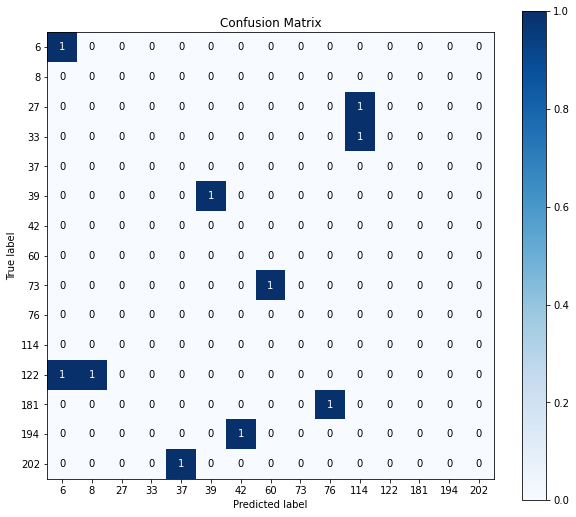

In [61]:
import scikitplot.metrics as splt

splt.plot_confusion_matrix(y_test[10:20], y_pred[10:20],figsize=(10,9))

In [ ]:
x[0]

In [53]:
attribution.shape

(2415, 24604)